In [17]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, random_split


import torchvision
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import pytorch_lightning as pl
torch.set_float32_matmul_precision('high')

In [18]:
from dotenv import load_dotenv
import os

DATASET_PATH = os.environ.get('DATASET_PATH',"./data")
DATASET_PATH += "/celeba/img_align_celeba/"
BATCH_SIZE = 2048*2 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 1.5)

In [19]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [20]:

## Create a custom Dataset class
class CelebADataset(torch.utils.data.Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = os.listdir(root_dir)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

In [24]:
class Celeba(pl.LightningDataModule):
    def __init__(self, root, imgsz, batchsz, no_workers):
        super(Celeba, self).__init__()
        self.root = root
        self.imgsz = imgsz
        self.batchsz = batchsz
        self.num_workers = no_workers

        self.transform = transforms.Compose(
            [transforms.Resize(self.imgsz),
             transforms.CenterCrop(self.imgsz),
             # transforms.Grayscale(num_output_channels=1),
             # transforms.AutoAugment(), #imagenet
               
             transforms.ToTensor(),
            transforms.Normalize(mean,std)
            ]
        )

    def setup(self, stage):
        if stage == "fit" or stage is None:
            self.train_dataset = CelebADataset(
                root_dir=self.root,transform=self.transform
            )


    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batchsz,
            shuffle=True,
            num_workers=self.num_workers,
        )


In [22]:
IMAGE_SIZE = 64
ds = Celeba(DATASET_PATH,IMAGE_SIZE,BATCH_SIZE,NUM_WORKERS)

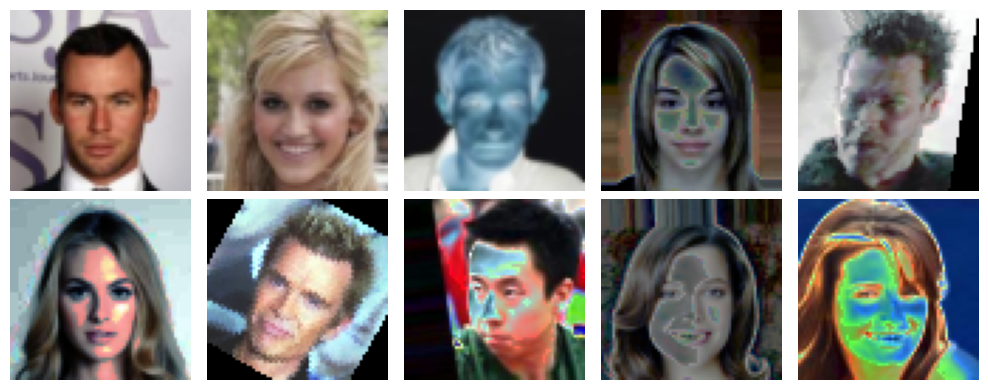

In [25]:
import matplotlib.pyplot as plt

# Sanity Check
ds.prepare_data()
ds.setup('fit')
dataloader = ds.train_dataloader()


# Create a dictionary to store one image per class
class_images = []

# Iterate over the dataset and store one image per class
for image in ds.train_dataset:

    class_images.append(image)
    if len(class_images) == 10:  # Stop after storing one image per class
        break

# Display the images from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, image in enumerate(class_images):
    ax = axes[i // 5, i % 5]
    image = (image * std.view( 3, 1, 1)) + mean.view( 3, 1, 1) 
    ax.imshow(image.permute(1,2,0))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [96]:

class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        def _block(in_feature, out_feature, normalize=True):
            layers = [nn.Linear(in_feature, out_feature)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feature,0.8))
            layers.append(nn.LeakyReLU(0.01))
            return layers

        self.g_model = nn.Sequential(
            *_block(latent_dim, 128, normalize=False),
            *_block(128, 256),
            *_block(256, 512),
            *_block(512, 1024),
            nn.Linear(1024, img_shape),
            nn.Tanh()
        )

    def forward(self, x):
        return self.g_model(x)


In [97]:
class Discriminator(nn.Module):
    def __init__(self,in_feature):
        super(Discriminator, self).__init__()

        self.d_model = nn.Sequential(
                                 nn.Linear(in_feature,512),
                                 nn.LeakyReLU(negative_slope=0.2),
                                 nn.Linear(512,256),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(256,1),
                                 nn.Sigmoid())

    def forward(self,x):
        return self.d_model(x)

In [98]:
class GAN(pl.LightningModule):
    def __init__(self,latent_dim,img_shape,lr,b1,b2):
        super().__init__()

        self.save_hyperparameters()

        self.generator = Generator(latent_dim,img_shape)
        self.discriminator = Discriminator(img_shape)

        self.automatic_optimization = False

    def forward(self,z):
        return self.generator(z)

    def adversarial_loss(self,y_hat,y):
        return nn.functional.binary_cross_entropy(y_hat,y)

    def training_step(self,batch,batch_idx):
        imgs = batch 

        # sample noise 
        z = torch.randn(imgs.shape[0],self.hparams.latent_dim).type_as(imgs)


        # ground truth 
        label_one = torch.ones(imgs.shape[0],1).type_as(imgs)
        label_zero = torch.zeros(imgs.shape[0],1).type_as(imgs)

        # Get optimizers
        g_opt, d_opt = self.optimizers()

        # Train Generator
        self.toggle_optimizer(g_opt)

        self.generated_img = self(z)

        #log 
        if not batch_idx % 500:
            sample_imgs = self.generated_img[:6]
            grid = torchvision.utils.make_grid(sample_imgs.view(-1,3,IMAGE_SIZE,IMAGE_SIZE))
            self.logger.experiment.add_image('generated_images',grid,self.current_epoch)
        
        g_loss = self.adversarial_loss(self.discriminator(self.generated_img),label_one)
        self.log('g_loss',g_loss,prog_bar=True)

        self.manual_backward(g_loss)
        g_opt.step()
        g_opt.zero_grad()
        self.untoggle_optimizer(g_opt)


        # Train discriminator
        self.toggle_optimizer(d_opt)
        # how well it can be label as real
        real_loss = self.adversarial_loss(self.discriminator(imgs.view(imgs.shape[0],-1)),label_one)
        # how well it can be label as fake
        fake_loss = self.adversarial_loss(self.discriminator(self.generated_img.detach()),label_zero)

        d_loss = (real_loss + fake_loss)/2
        self.log('d_loss',d_loss,prog_bar=True)

        self.manual_backward(d_loss)
        d_opt.step()
        d_opt.zero_grad()
        self.untoggle_optimizer(d_loss)


    def validation_step(self,batch):
        pass


    def configure_optimizers(self):
        g_opt = torch.optim.AdamW(self.generator.parameters(),lr=self.hparams.lr, betas=[self.hparams.b1,self.hparams.b2])
        d_opt = torch.optim.AdamW(self.discriminator.parameters(),lr=self.hparams.lr, betas=[self.hparams.b1,self.hparams.b2])            
            
        return [g_opt,d_opt], []

    def on_validation_batch_end(self):
        validation_noise = torch.randn(8,self.hparams.latent_dim).type_as(self.generator.model[0].weight)
                    
        #log 
        sample_imgs = self(validation_noise)
        grid = torchvision.utils.make_grid(sample_imgs.view(-1,3,IMAGE_SIZE,IMAGE_SIZE))
        self.logger.experiment.add_image('Validation_z',grid,self.current_epoch)
        

In [99]:
latent_dim, img_shape, lr, b1, b2 = 100, 3*IMAGE_SIZE*IMAGE_SIZE, 2e-4, 0.5, 0.999
model = GAN(latent_dim, img_shape, lr, b1,b2)

In [100]:
# model = torch.compile(model)

In [101]:
trainer = pl.Trainer(min_epochs=1,
                        max_epochs=2000 ,
                        # precision='16-mixed',
                        enable_model_summary=False,
                        # callbacks=[pl.callbacks.EarlyStopping('d_loss',min_delta=0.0,patience=5)],
                        enable_checkpointing  = True,
                        log_every_n_steps=10
                    )
trainer.fit(model,ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |                                               | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined